<a href="https://colab.research.google.com/github/daniswara10/DeteksiPapanNamaRuangFilkom/blob/main/DeteksiPapanNamaRuangFilkom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install ultralytics
!pip install torch torchvision torchaudio
!pip install matplotlib opencv-python
!pip install seaborn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 871.9/871.9 kB 16.4 MB/s eta 0:00:00


In [2]:
pip install ultralytics

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import torch
import torch.nn as nn
from transformers import ViTModel

# CNN Backbone
class CNNBackbone(nn.Module):
    def __init__(self):
        super(CNNBackbone, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(128 * 32 * 32, 512)  # assuming 32x32 image size after conv layers

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 128 * 32 * 32)  # flatten feature map
        x = F.relu(self.fc(x))
        return x

# Transformer head
class CvTModel(nn.Module):
    def __init__(self):
        super(CvTModel, self).__init__()
        self.cnn_backbone = CNNBackbone()
        self.transformer = ViTModel.from_pretrained('google/vit-base-patch16-224')

    def forward(self, x):
        cnn_features = self.cnn_backbone(x)
        transformer_input = cnn_features.unsqueeze(1)  # adjust shape for transformer
        transformer_output = self.transformer(transformer_input)
        return transformer_output.last_hidden_state


In [ ]:
from ultralytics import YOLO

# Load YOLO model with custom CvT backbone
model = YOLO("yolov8n.pt")  # Use a pre-trained YOLO model

# Train the model with CvT
results = model.train(data="/content/drive/MyDrive/DeteksiPapanNama/data.yaml", epochs=25, imgsz=640)


In [6]:
from ultralytics import YOLO
import numpy as np

class EarlyStopping:
    def __init__(self, patience=10, delta=0, verbose=False):
        """
        :param patience: Jumlah epoch untuk menunggu jika tidak ada perbaikan
        :param delta: Perubahan minimum yang dianggap sebagai perbaikan
        :param verbose: Menampilkan informasi tambahan jika True
        """
        self.patience = patience
        self.delta = delta
        self.verbose = verbose
        self.best_score = np.inf  # Untuk loss lebih rendah, set initial score ke inf
        self.early_stop = False
        self.counter = 0

    def __call__(self, score):
        if self.best_score - score > self.delta:
            self.best_score = score
            self.counter = 0
        else:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True

# Definisikan model, misalnya YOLOv8
model = YOLO('/content/drive/MyDrive/DeteksiPapanNama/best.pt')  # Atau model yang Anda pilih

# Setup early stopping
early_stopping = EarlyStopping(patience=5, verbose=True)

# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    # Train model for one epoch
    results = model.train(data='/content/drive/MyDrive/DeteksiPapanNama/data.yaml', epochs=1, batch=16, imgsz=640, save=True, exist_ok=True)

    # Coba akses loss dari hasil pelatihan
    try:
        if hasattr(results, 'metrics'):
            # Misalkan 'loss' berada di dalam 'results.metrics'
            val_loss = results.metrics.get('loss', np.inf)
        else:
            # Alternatif: Cek dokumentasi atau hasil pelatihan
            print("Metrics tidak tersedia dalam hasil pelatihan")
            val_loss = np.inf
    except Exception as e:
        print(f'Error saat mengambil loss: {e}')
        val_loss = np.inf

    print(f'Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss:.4f}')

    # Panggil early stopping
    early_stopping(val_loss)

    if early_stopping.early_stop:
        print("Early stopping")
        break


Ultralytics YOLOv8.2.92 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=/content/drive/MyDrive/DeteksiPapanNama/best.pt, data=/content/drive/MyDrive/DeteksiPapanNama/data.yaml, epochs=1, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False

100%|██████████| 755k/755k [00:00<00:00, 16.3MB/s]



                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128

100%|██████████| 6.25M/6.25M [00:00<00:00, 75.6MB/s]


AMP: checks passed ✅


train: Scanning /content/drive/MyDrive/DeteksiPapanNama/train/labels.cache... 2322 images, 15 backgrounds, 0 corrupt: 100%|██████████| 2322/2322 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/drive/MyDrive/DeteksiPapanNama/val/labels.cache... 96 images, 0 backgrounds, 0 corrupt: 100%|██████████| 96/96 [00:00<?, ?it/s]


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000104, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 1 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/1      2.46G       1.28       3.21      1.252          5        640: 100%|██████████| 146/146 [01:54<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.56s/it]


                   all         96         96      0.418      0.433      0.471      0.317

1 epochs completed in 0.039 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.8MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.8MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.2.92 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,262,316 parameters, 0 gradients, 9.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.14it/s]


                   all         96         96      0.423      0.433      0.472      0.318
F 10 1 1 RUANG KEPALA PSIK          2          2      0.339        0.5      0.578      0.439
 F 10 1 RUANG HELPDESK          2          2          0          0      0.117     0.0885
F 10 2 RUANG AUDIO CONTROL          2          2      0.248        0.5      0.201      0.181
F 10 4 RUANG VIDEO PRODUCTION          1          1      0.246          1      0.995      0.895
F 10 5 RUANG SE DAN WORKSHOP          1          1          1          0      0.124     0.0871
     F 11 2 RUANGKELAS          1          1      0.312          1      0.995      0.895
F 11 3  RUANG KELAS S2          1          1      0.287          1      0.995      0.796
F 11 4  RUANG KELAS S2          2          2      0.443        0.5      0.414       0.35
F 11 5 RUANG LABORATORIUM          1          1          0          0      0.111     0.0663
    F 11 8 RUANG KELAS          1          1          1          0      0.332      0.2

train: Scanning /content/drive/MyDrive/DeteksiPapanNama/train/labels.cache... 2322 images, 15 backgrounds, 0 corrupt: 100%|██████████| 2322/2322 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/drive/MyDrive/DeteksiPapanNama/val/labels.cache... 96 images, 0 backgrounds, 0 corrupt: 100%|██████████| 96/96 [00:00<?, ?it/s]


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000104, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 1 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/1      2.74G      1.167      3.013      1.202          5        640: 100%|██████████| 146/146 [01:40<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.61s/it]


                   all         96         96      0.411      0.429      0.479      0.317

1 epochs completed in 0.038 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.8MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.8MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.2.92 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,262,316 parameters, 0 gradients, 9.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.38it/s]


                   all         96         96      0.412      0.428      0.479      0.317
F 10 1 1 RUANG KEPALA PSIK          2          2      0.364        0.5      0.572      0.436
 F 10 1 RUANG HELPDESK          2          2          0          0      0.117     0.0903
F 10 2 RUANG AUDIO CONTROL          2          2      0.252        0.5      0.208      0.188
F 10 4 RUANG VIDEO PRODUCTION          1          1      0.337          1      0.995      0.895
F 10 5 RUANG SE DAN WORKSHOP          1          1          1          0      0.142     0.0995
     F 11 2 RUANGKELAS          1          1      0.309          1      0.497      0.448
F 11 3  RUANG KELAS S2          1          1      0.333          1      0.995      0.796
F 11 4  RUANG KELAS S2          2          2      0.453      0.453      0.448       0.37
F 11 5 RUANG LABORATORIUM          1          1          0          0     0.0995     0.0597
    F 11 8 RUANG KELAS          1          1          1          0      0.332      0.2

train: Scanning /content/drive/MyDrive/DeteksiPapanNama/train/labels.cache... 2322 images, 15 backgrounds, 0 corrupt: 100%|██████████| 2322/2322 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/drive/MyDrive/DeteksiPapanNama/val/labels.cache... 96 images, 0 backgrounds, 0 corrupt: 100%|██████████| 96/96 [00:00<?, ?it/s]


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000104, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 1 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/1      2.74G       1.08      2.869      1.165          5        640: 100%|██████████| 146/146 [01:43<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:05<00:00,  1.92s/it]


                   all         96         96      0.497      0.407      0.482      0.328

1 epochs completed in 0.044 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.8MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.8MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.2.92 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,262,316 parameters, 0 gradients, 9.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.13it/s]


                   all         96         96      0.496      0.407      0.483      0.329
F 10 1 1 RUANG KEPALA PSIK          2          2      0.366        0.5      0.572      0.386
 F 10 1 RUANG HELPDESK          2          2          0          0      0.138      0.114
F 10 2 RUANG AUDIO CONTROL          2          2      0.262        0.5       0.21      0.189
F 10 4 RUANG VIDEO PRODUCTION          1          1      0.505          1      0.995      0.895
F 10 5 RUANG SE DAN WORKSHOP          1          1          1          0      0.142     0.0995
     F 11 2 RUANGKELAS          1          1      0.443          1      0.497      0.448
F 11 3  RUANG KELAS S2          1          1      0.469          1      0.995      0.895
F 11 4  RUANG KELAS S2          2          2      0.394      0.394      0.663      0.541
F 11 5 RUANG LABORATORIUM          1          1          0          0     0.0905     0.0543
    F 11 8 RUANG KELAS          1          1          1          0      0.332      0.2

train: Scanning /content/drive/MyDrive/DeteksiPapanNama/train/labels.cache... 2322 images, 15 backgrounds, 0 corrupt: 100%|██████████| 2322/2322 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/drive/MyDrive/DeteksiPapanNama/val/labels.cache... 96 images, 0 backgrounds, 0 corrupt: 100%|██████████| 96/96 [00:00<?, ?it/s]


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000104, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 1 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/1      2.74G      1.006       2.74      1.136          5        640: 100%|██████████| 146/146 [01:44<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:05<00:00,  1.76s/it]


                   all         96         96      0.452      0.456      0.488      0.329

1 epochs completed in 0.043 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.8MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.8MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.2.92 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,262,316 parameters, 0 gradients, 9.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.17s/it]


                   all         96         96      0.453      0.456      0.488      0.329
F 10 1 1 RUANG KEPALA PSIK          2          2      0.401        0.5      0.562      0.431
 F 10 1 RUANG HELPDESK          2          2          0          0      0.124     0.0879
F 10 2 RUANG AUDIO CONTROL          2          2      0.251        0.5      0.293      0.237
F 10 4 RUANG VIDEO PRODUCTION          1          1      0.445          1      0.995      0.895
F 10 5 RUANG SE DAN WORKSHOP          1          1          1          0      0.199      0.139
     F 11 2 RUANGKELAS          1          1      0.322          1      0.332      0.265
F 11 3  RUANG KELAS S2          1          1       0.36          1      0.995      0.895
F 11 4  RUANG KELAS S2          2          2      0.414      0.414      0.663      0.542
F 11 5 RUANG LABORATORIUM          1          1          0          0     0.0995     0.0597
    F 11 8 RUANG KELAS          1          1          1          0      0.332      0.2

train: Scanning /content/drive/MyDrive/DeteksiPapanNama/train/labels.cache... 2322 images, 15 backgrounds, 0 corrupt: 100%|██████████| 2322/2322 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/drive/MyDrive/DeteksiPapanNama/val/labels.cache... 96 images, 0 backgrounds, 0 corrupt: 100%|██████████| 96/96 [00:00<?, ?it/s]


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000104, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 1 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/1      2.74G     0.9451       2.62      1.111          5        640: 100%|██████████| 146/146 [01:53<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.27s/it]


                   all         96         96      0.447      0.433      0.493      0.331

1 epochs completed in 0.044 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.8MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.8MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.2.92 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,262,316 parameters, 0 gradients, 9.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.11it/s]


                   all         96         96      0.446      0.433      0.494      0.333
F 10 1 1 RUANG KEPALA PSIK          2          2      0.374        0.5      0.566      0.433
 F 10 1 RUANG HELPDESK          2          2          0          0      0.145      0.119
F 10 2 RUANG AUDIO CONTROL          2          2      0.266        0.5      0.297      0.238
F 10 4 RUANG VIDEO PRODUCTION          1          1       0.34          1      0.995      0.895
F 10 5 RUANG SE DAN WORKSHOP          1          1          1          0      0.199      0.139
     F 11 2 RUANGKELAS          1          1      0.243          1      0.332      0.298
F 11 3  RUANG KELAS S2          1          1      0.205          1      0.995      0.895
F 11 4  RUANG KELAS S2          2          2      0.499      0.499      0.663        0.5
F 11 5 RUANG LABORATORIUM          1          1          0          0      0.142     0.0853
    F 11 8 RUANG KELAS          1          1          1          0      0.332      0.2

Ultralytics YOLOv8.2.92 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,262,316 parameters, 0 gradients, 9.2 GFLOPs


val: Scanning /content/drive/MyDrive/DeteksiPapanNama/val/labels.cache... 96 images, 0 backgrounds, 0 corrupt: 100%|██████████| 96/96 [00:00<?, ?it/s]
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.41it/s]


                   all         96         96      0.446      0.435      0.494      0.329
F 10 1 1 RUANG KEPALA PSIK          2          2      0.373        0.5      0.572      0.436
 F 10 1 RUANG HELPDESK          2          2          0          0      0.145      0.125
F 10 2 RUANG AUDIO CONTROL          2          2      0.266        0.5      0.297      0.238
F 10 4 RUANG VIDEO PRODUCTION          1          1      0.341          1      0.995      0.895
F 10 5 RUANG SE DAN WORKSHOP          1          1          1          0      0.199      0.139
     F 11 2 RUANGKELAS          1          1      0.243          1      0.332      0.265
F 11 3  RUANG KELAS S2          1          1      0.206          1      0.995      0.895
F 11 4  RUANG KELAS S2          2          2      0.499      0.499      0.663        0.5
F 11 5 RUANG LABORATORIUM          1          1          0          0      0.142     0.0853
    F 11 8 RUANG KELAS          1          1          1          0      0.332      0.2

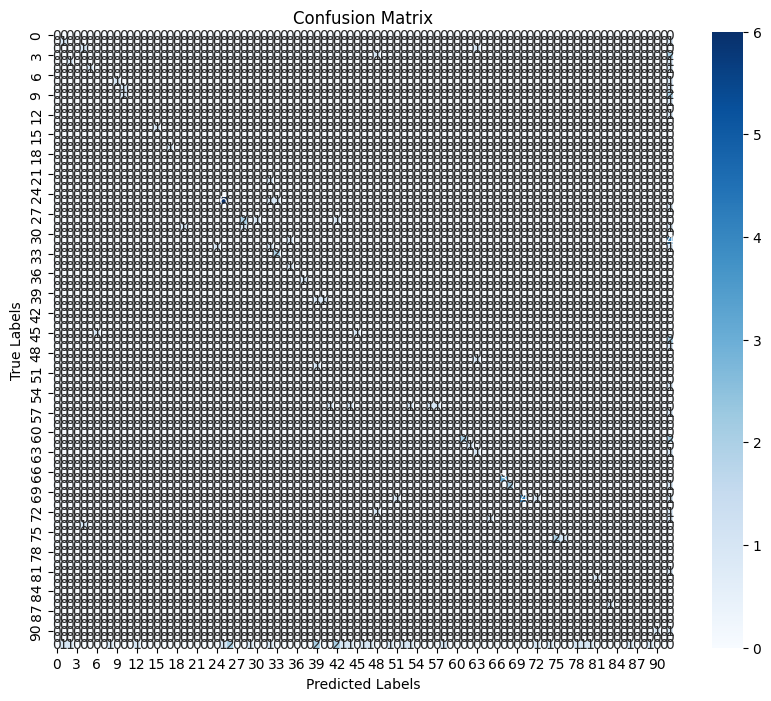

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Lakukan validasi model
results = model.val()

# Ambil data confusion matrix
conf_matrix = results.confusion_matrix.matrix

# Coba konversi ConfusionMatrix ke numpy array (misalnya, jika itu objek khusus)
try:
    conf_matrix = np.array(conf_matrix)  # Mengonversi ke numpy array
except:
    print("Gagal mengonversi confusion matrix menjadi array.")

# Pastikan confusion_matrix sekarang adalah array 2D
if conf_matrix is not None and len(conf_matrix.shape) == 2:
    # Visualisasikan confusion matrix dengan Seaborn
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt=".0f", cmap="Blues")
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()
else:
    print("Confusion matrix tidak tersedia atau tidak berbentuk 2D.")


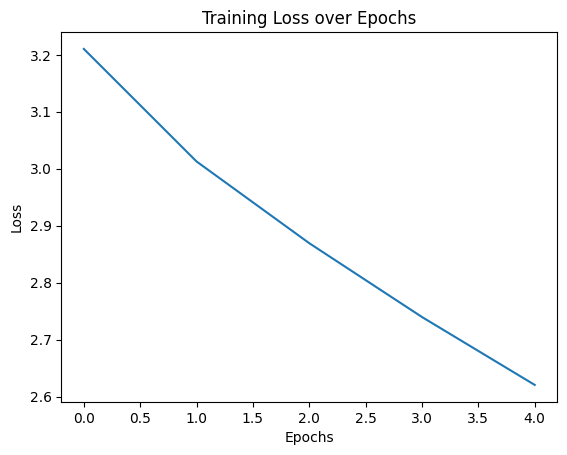

In [12]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv('/content/runs/detect/train/results.csv')
loss = df['         train/cls_loss']


# Extract epoch and loss values
epochs = [i for i in range(len(loss))]
losses = [metric for metric in loss]

plt.plot(epochs, losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.show()


In [27]:
# Memuat model YOLOv8 dengan CvT yang sudah dilatih
model = YOLO('/content/runs/detect/train/weights/best.pt')  # Ganti dengan path model Anda

# Menampilkan parameter model (weights dan biases)
for name, param in model.model.named_parameters():  # Akses model dari objek YOLO
    print(f"Parameter Name: {name}")
    print(f"Parameter Value: {param}")
    print(f"Parameter Size: {param.size()}")
    print('-' * 80)

Streaming output truncated to the last 5000 lines.

         [[-2.1484e-02,  2.4586e-03, -1.8768e-02],
          [-9.0790e-03, -4.4067e-02,  1.4824e-02],
          [-9.6283e-03,  9.8877e-03, -8.1177e-03]],

         [[ 1.4313e-02, -2.4796e-02,  1.1803e-02],
          [-2.7943e-03, -5.3635e-03, -8.1406e-03],
          [-2.4078e-02,  2.2537e-02,  5.6229e-03]]],


        [[[ 5.3902e-03,  1.2436e-03, -4.0665e-03],
          [ 3.2616e-03, -8.2703e-03,  4.5776e-03],
          [-6.0844e-03, -1.7548e-02, -3.5915e-03]],

         [[-4.0131e-03,  1.6373e-02,  1.2352e-02],
          [ 1.2589e-02,  2.9282e-02, -8.8501e-04],
          [-7.6141e-03, -1.4664e-02, -3.6346e-02]],

         [[ 2.2221e-03,  1.2756e-02,  9.0714e-03],
          [-1.1002e-02, -1.7670e-02, -1.4458e-02],
          [-3.7018e-02, -2.4857e-02,  1.4439e-03]],

         ...,

         [[ 2.8491e-05,  1.2894e-02, -9.2850e-03],
          [-2.0340e-02,  2.0466e-03,  6.2561e-03],
          [ 2.5894e-02,  1.8219e-02,  4.4479e-03]],

 

In [37]:
print(model.info())

Model summary: 225 layers, 3,267,684 parameters, 3,267,668 gradients, 9.4 GFLOPs
(225, 3267684, 3267668, 9.3607424)


In [38]:
import time
from ultralytics import YOLO

# Memuat model YOLOv8 dengan CvT yang sudah dilatih
model = YOLO('/content/runs/detect/train/weights/best.pt')  # Ganti dengan path model Anda

# Mengukur waktu deteksi pada data uji
start_time = time.time()
results = model.val()  # Melakukan validasi pada data uji
end_time = time.time()

# Menghitung waktu deteksi
inference_time = end_time - start_time
print(f"Validation Time: {inference_time:.4f} seconds")


Ultralytics YOLOv8.2.92 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,262,316 parameters, 0 gradients, 9.2 GFLOPs


val: Scanning /content/drive/MyDrive/DeteksiPapanNama/val/labels.cache... 96 images, 0 backgrounds, 0 corrupt: 100%|██████████| 96/96 [00:00<?, ?it/s]
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.07it/s]


                   all         96         96      0.446      0.435      0.494      0.329
F 10 1 1 RUANG KEPALA PSIK          2          2      0.373        0.5      0.572      0.436
 F 10 1 RUANG HELPDESK          2          2          0          0      0.145      0.125
F 10 2 RUANG AUDIO CONTROL          2          2      0.266        0.5      0.297      0.238
F 10 4 RUANG VIDEO PRODUCTION          1          1      0.341          1      0.995      0.895
F 10 5 RUANG SE DAN WORKSHOP          1          1          1          0      0.199      0.139
     F 11 2 RUANGKELAS          1          1      0.243          1      0.332      0.265
F 11 3  RUANG KELAS S2          1          1      0.206          1      0.995      0.895
F 11 4  RUANG KELAS S2          2          2      0.499      0.499      0.663        0.5
F 11 5 RUANG LABORATORIUM          1          1          0          0      0.142     0.0853
    F 11 8 RUANG KELAS          1          1          1          0      0.332      0.2